In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation, RandomCrop, GaussianBlur, ToPILImage

# Configuration

In [2]:
config = {
  "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
  "batch_size": 1,
  "learning_rate": 1e-4,
  "eta_min": 1e-6,
  "epoch_num": 600,
  "scale_factor": 4,
  "augmentation": True
}

# Dataloader & Dataset

In [3]:
import re

def sorted_alphanumeric(data):

    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, low_path, high_path, size = 256, augment=False, x2_pretrained=False):
        self.size = size
        self.low_path = low_path
        self.high_path = high_path
        self.augment = augment
        self.x2_pretrained = x2_pretrained
        self.high_files = sorted_alphanumeric(os.listdir(high_path))
        self.low_files = sorted_alphanumeric(os.listdir(low_path))

        # Data augmentation
        self.random_horizontal_flip = RandomHorizontalFlip(p=1)
        self.random_vertical_flip = RandomVerticalFlip(p=1)
        self.random_rotation = RandomRotation(10)  # Rotate by 10 degrees
        self.color_jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)

    def __len__(self):
        return len(self.low_files)
    
    def apply_same_transform(self, high_img, low_img):
        # Convert to PIL images for augmentation
        high_img = ToPILImage()(high_img)
        low_img = ToPILImage()(low_img)

        # Random Horizontal Flip
        if random.random() > 0.5:
            high_img = self.random_horizontal_flip(high_img)
            low_img = self.random_horizontal_flip(low_img)

        # Random Vertical Flip
        if random.random() > 0.5:
            high_img = self.random_vertical_flip(high_img)
            low_img = self.random_vertical_flip(low_img)

        return high_img, low_img

    def __getitem__(self, idx):

        high_img_path = os.path.join(self.high_path, self.high_files[idx])
        low_img_path = os.path.join(self.low_path, self.low_files[idx])

        high_img = cv2.imread(high_img_path, 1)
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
        high_img = cv2.resize(high_img, (self.size, self.size))
        high_img = high_img.astype('float32') / 255.0

        low_img = cv2.imread(low_img_path, 1)
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        if self.x2_pretrained:
            low_img = cv2.resize(low_img, (self.size//2, self.size//2))
        else: 
            low_img = cv2.resize(low_img, (self.size//4, self.size//4))
        low_img = low_img.astype('float32') / 255.0

        if self.augment:
            high_img, low_img = self.apply_same_transform(high_img, low_img)

        return {
            'high_img': ToTensor()(high_img),
            'low_img': ToTensor()(low_img)
        }

In [5]:
high_res_path = 'C:/Users/User/Downloads/Data/Train set/high_res'
low_res_path = 'C:/Users/User/Downloads/Data/Train set/low_res'
test_high_res_path = 'C:/Users/User/Downloads/Data/Test set/high_res'
test_low_res_path = 'C:/Users/User/Downloads/Data/Test set/low_res'

# Create dataset instance
dataset = ImageDataset(low_res_path, high_res_path, augment=config['augmentation'], x2_pretrained=False)
test_set = ImageDataset(test_low_res_path, test_high_res_path, augment=False, x2_pretrained=False)

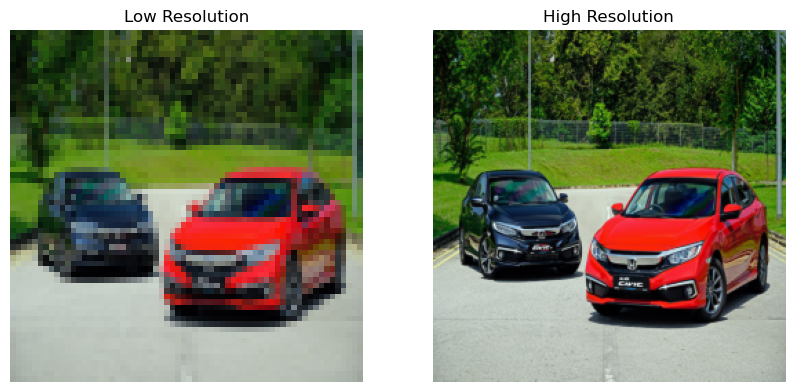

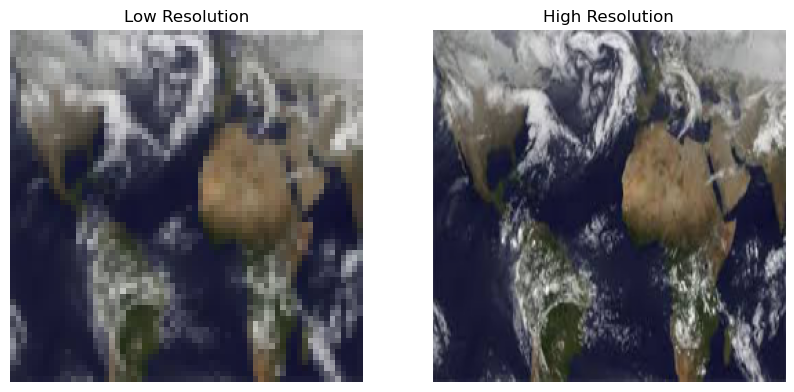

In [6]:
import matplotlib.pyplot as plt
import cv2
num_pairs_to_print = 2

for idx in range(num_pairs_to_print):
    sample = dataset[idx]
    high_img, low_img = sample['high_img'], sample['low_img']
    #Convert the pytorch tensors to numpy arrays
    #Matplotlib expects the images to be in the format : height, width, channels whereas the the pytroch tensor has it in the form of channels, height, width
    #After doing this we convert to the numpy array
    high_img_np = high_img.permute(1, 2, 0).numpy() if high_img.shape[0] == 3 else high_img.numpy()
    low_img_np = low_img.permute(1, 2, 0).numpy() if low_img.shape[0] == 3 else low_img.numpy()

    # Plot high-resolution and low-resolution images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(low_img_np)
    plt.title('Low Resolution')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(high_img_np)
    plt.title('High Resolution')
    plt.axis('off')

    plt.show()


In [7]:
from torch.utils.data import random_split

print("Number of high-resolution images:", len(dataset.high_files))
print("Number of low-resolution images:", len(dataset.low_files))
print("Number of Test high-resolution images:", len(test_set.high_files))
print("Number of Test low-resolution images:", len(test_set.low_files))

train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
# Split the dataset into train, validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])
print("Length of training set is: ", len(train_set))
print("Length of validation set is: ", len(val_set))
print("Length of testing set is: ", len(test_set))


Number of high-resolution images: 360
Number of low-resolution images: 360
Number of Test high-resolution images: 40
Number of Test low-resolution images: 40
Length of training set is:  288
Length of validation set is:  72
Length of testing set is:  40


In [8]:
batch_size = config['batch_size']
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# MODEL : SRResNet

In [9]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#build your model here
class SRResNet(nn.Module):
    def __init__(self, block_num=16, hidden_channels=64, upscale_factor=2):
        super(SRResNet, self).__init__()
        # parameters
        self.block_num = block_num
        self.hidden_channels = hidden_channels
        self.upscale_factor = upscale_factor

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_channels, kernel_size=9, stride=1, padding=4)
        self.act1 = nn.PReLU()

        self.residualBlock = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.PReLU(), 
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_channels),
        )

        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)

        self.upsampleBlock = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels*(2**2), kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        self.conv3 = nn.Conv2d(in_channels=hidden_channels, out_channels=3, kernel_size=9, stride=1, padding=4)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        identity1 = x

        for i in range(self.block_num):
            identity_block = x
            x = self.residualBlock(x)
            x = x + identity_block
        
        x = self.bn1(self.conv2(x))
        x = x + identity1

        # Adjust upscale block by the scale factor
        for j in range(self.upscale_factor // 2):
            x = self.upsampleBlock(x)
        
        x = self.conv3(x)

        return x

# Test Model Size

In [10]:
#call model
model = SRResNet(upscale_factor=config['scale_factor'])
model = model.to(config['device'])

from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,928
      BatchNorm2d-14           [-1, 64,

# Training

In [11]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [12]:
import torch.optim as optim

# Loss function
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=config['epoch_num']*len(train_set)//(config['batch_size']*4),   # The number of epochs before the first restart
    T_mult=1,   # Multiplier for increasing the cycle length
    eta_min=config['eta_min']  # Minimum learning rate
)

In [13]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
# num_epochs : You can try 10~15 at first.
num_epochs = config['epoch_num']
psnr_best = 0.0
best_val_loss = np.Inf
history = []
filename = f'model.pth'


# load saved best model to start training
if os.path.isfile(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    psnr_best = checkpoint['best_psnr']
    print(f"Loading best model with PSNR = {psnr_best:.4f}")
else:
    print('No saved model found. Start training ...')


for epoch in range(num_epochs):
    train_loss  = 0.0
    lrs         = []
    result      = {'train_loss': [], 'valid_loss': [], 'lrs': [], 'train_psnr': [], 'valid_psnr': []}
    
    # Training phase
    running_loss = 0.0
    train_psnr_total = 0
    running_len = 0

    # with tqdm(total=len(train_set)//config['batch_size'], desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False) as pbar:
    for batch_idx, data in enumerate(train_loader):
        low_img, high_img = data['low_img'].to(config['device']), data['high_img'].to(config['device'])

        # Please finish the "Training phase" code here.
        optimizer.zero_grad()
        output_img = model(low_img)
        running_loss = criterion(output_img, high_img)
        running_loss.backward()
        optimizer.step()

        lrs.append(optimizer.param_groups[0]['lr'])
        train_loss += running_loss.item()*high_img.size(0)
        train_psnr_total += calculate_psnr(output_img, high_img)
        running_len += 1

        # pbar.set_postfix({"Train Loss": train_loss / running_len, "PSNR": train_psnr_total / running_len, "Learning rate":optimizer.param_groups[0]['lr']})
        # pbar.update(1)

        scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0
    psnr_total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        # for lr_imgs, hr_imgs in tqdm(val_loader, desc='Validation', leave=False):
            lr_imgs, hr_imgs = data['low_img'].to(device), data['high_img'].to(device)

            # Please finish the "Validation phase" code here.
            output_img = model(lr_imgs)
            running_loss = criterion(output_img, hr_imgs)
            val_loss += running_loss.item() * hr_imgs.size(0)

            # Calculate PSNR for validation images
            psnr_total += calculate_psnr(output_img, hr_imgs)

    epoch_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_train_psnr = train_psnr_total / len(train_loader)
    avg_psnr = psnr_total / len(val_loader)

    # scheduler.step(avg_val_loss)

    result['train_loss'] = epoch_loss
    result['valid_loss'] = avg_val_loss
    result['lrs'] = lrs
    result['train_psnr'] = avg_train_psnr
    result['valid_psnr'] = avg_psnr
    history.append(result)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print(f'Epoch {epoch + 1}/{num_epochs}  Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | PSNR: {avg_psnr:.2f} dB | LR: {current_lr:.2e}')

    if avg_psnr >= psnr_best:
        psnr_best = avg_psnr

        state = {
            'model_state_dict': model.state_dict(),
            'best_psnr': psnr_best
        }
        print(f"Save new best model with PSNR = {psnr_best:.4f}")
        torch.save(state, filename)

No saved model found. Start training ...
Epoch 1/600  Train Loss: 0.1130 | Val Loss: 0.1295 | PSNR: 15.44 dB | LR: 1.00e-04
Save new best model with PSNR = 15.4360
Epoch 2/600  Train Loss: 0.0918 | Val Loss: 0.0814 | PSNR: 18.97 dB | LR: 1.00e-04
Save new best model with PSNR = 18.9673
Epoch 3/600  Train Loss: 0.0691 | Val Loss: 0.0741 | PSNR: 19.86 dB | LR: 9.99e-05
Save new best model with PSNR = 19.8621
Epoch 4/600  Train Loss: 0.0593 | Val Loss: 0.0621 | PSNR: 21.02 dB | LR: 9.98e-05
Save new best model with PSNR = 21.0182
Epoch 5/600  Train Loss: 0.0540 | Val Loss: 0.0582 | PSNR: 21.66 dB | LR: 9.97e-05
Save new best model with PSNR = 21.6632
Epoch 6/600  Train Loss: 0.0525 | Val Loss: 0.0624 | PSNR: 21.47 dB | LR: 9.96e-05
Epoch 7/600  Train Loss: 0.0488 | Val Loss: 0.0517 | PSNR: 22.55 dB | LR: 9.95e-05
Save new best model with PSNR = 22.5495
Epoch 8/600  Train Loss: 0.0453 | Val Loss: 0.0702 | PSNR: 21.02 dB | LR: 9.93e-05
Epoch 9/600  Train Loss: 0.0471 | Val Loss: 0.0470 | PS

PSNR for the testing data: 25.67 dB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


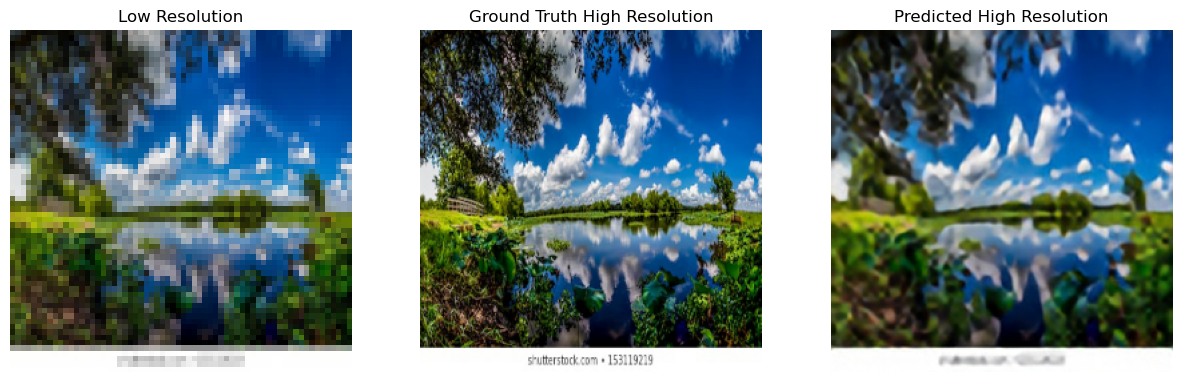

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


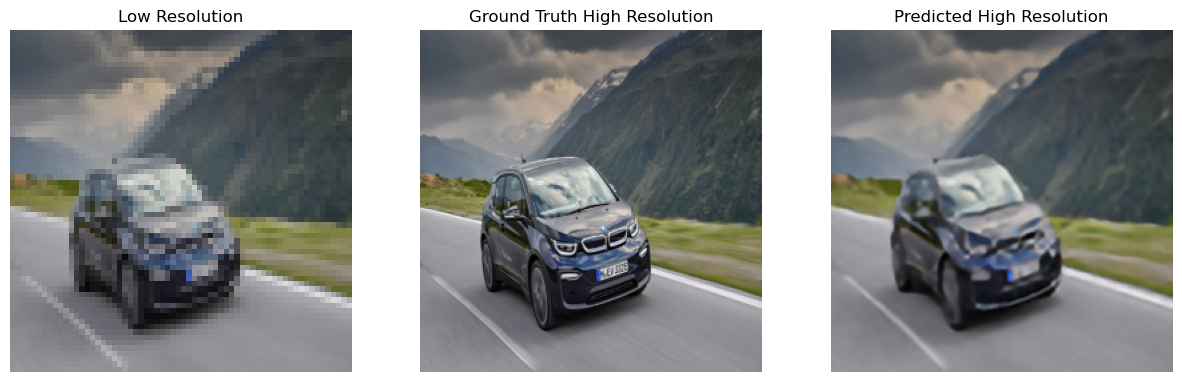

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


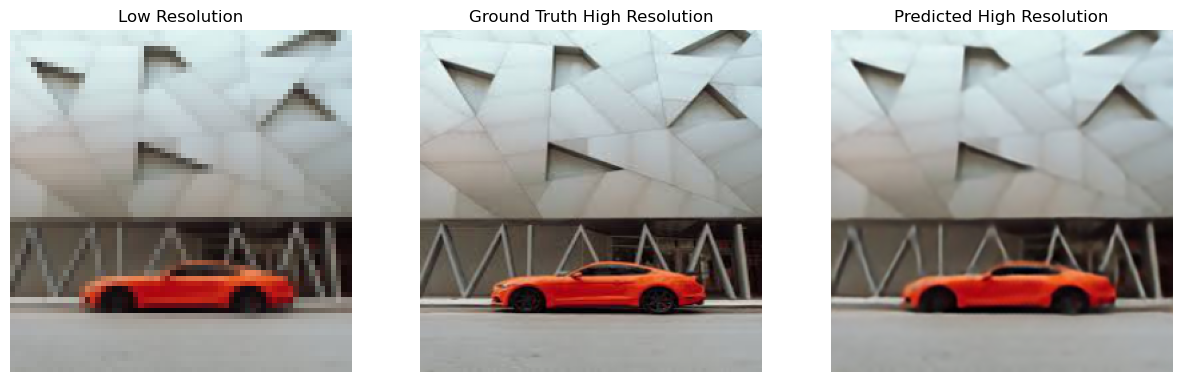

In [18]:
# load the model so that you don't need to train the model again
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['model_state_dict'])
# model = torch.load("model.pth").to(device)

# Set the model to evaluation mode
model.eval()
total_test_psnr = 0.0

# Run the model to get the reconstructed high-resolution images
with torch.no_grad():
  for test_batch in test_loader:
    # Move the low-res and high-res images to the same device as the model
    low_img = test_batch['low_img'].to(device)
    high_img = test_batch['high_img'].to(device)    
    predicted_img = model(low_img)
    # Calculate PSNR for the current batch and accumulate the results
    psnr_value = calculate_psnr(predicted_img, high_img)
    total_test_psnr += psnr_value

test_psnr = total_test_psnr / len(test_loader)
print(f"PSNR for the testing data: {test_psnr:.2f} dB")

# Convert the tensors back to numpy arrays for visualization
high_img_np = high_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)
low_img_np = low_img.cpu().permute(0, 2, 3, 1).numpy()    # (batch_size, height, width, channels)
predicted_img_np = predicted_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)

# Plot some sample results
num_samples = 3  # Adjust this to show more/less samples
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Low resolution image
    plt.subplot(1, 3, 1)
    plt.imshow(low_img_np[i])
    plt.title('Low Resolution')
    plt.axis('off')

    # Ground truth high resolution image
    plt.subplot(1, 3, 2)
    plt.imshow(high_img_np[i])
    plt.title('Ground Truth High Resolution')
    plt.axis('off')

    # Predicted high resolution image
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img_np[i])
    plt.title('Predicted High Resolution')
    plt.axis('off')

    plt.show()

# Plotting

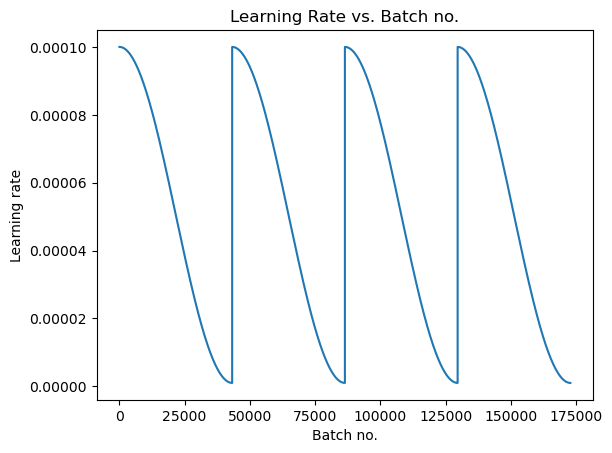

In [15]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

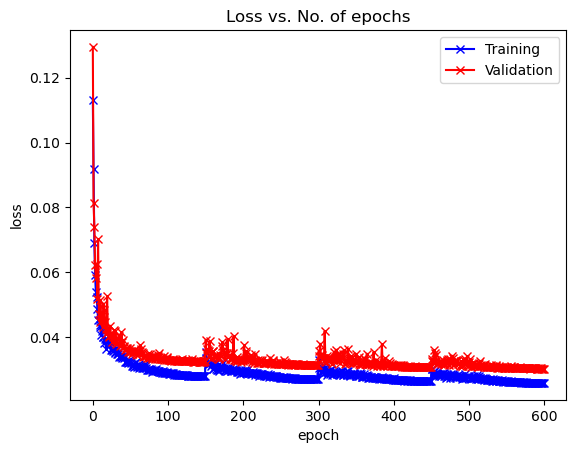

In [16]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_losses(history)

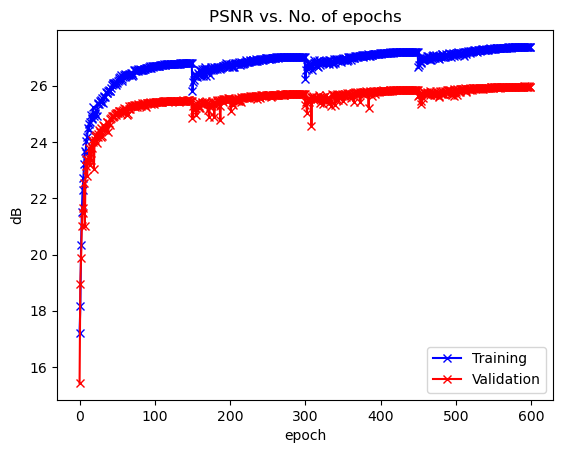

In [17]:
def plot_psnr(history):
  train_psnr = [x.get('train_psnr') for x in history]
  valid_psnr = [x.get('valid_psnr') for x in history]
  plt.plot(train_psnr, '-bx')
  plt.plot(valid_psnr, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('dB')
  plt.legend(['Training', 'Validation'])
  plt.title('PSNR vs. No. of epochs')

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_psnr(history)